In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geoip2.database
import maxminddb

In [3]:
# config
# json_path = '../datasets/raw/dns_records/crux_top1k_cctld/'
# json_path_google = '../datasets/raw/dns_records/crux_top1k_cctld_googledns-new/'
# json_path_cloudflare = '../datasets/raw/dns_records/crux_top1k_cctld_cloudflaredns-new/'

ipinfo_mmdb = '../datasets/standard_location.mmdb'
complete_data_path = '../../isoc/custom-datasets/raw/20240930/top1k_cctld/'

In [36]:
def get_ip_country(mmdb_file,ip):
    with geoip2.database.Reader(mmdb_file) as reader:
        response = reader.country(ip)
        return response.country.iso_code
    
def get_ip_loc(mmdb_file,ip):
    if pd.isna(ip):
        return np.nan
    try:
        with maxminddb.open_database(mmdb_file) as reader:
            return reader.get(ip)
    except Exception as e:
        return np.nan
    
def get_ip_country2(mmdb_file,ip):
    res=get_ip_loc(mmdb_file,ip)
    if not pd.isna(res):
        return res['country']
    else:
        return ''


In [10]:
df = pd.concat([pd.read_csv(complete_data_path+fname,index_col=0) for fname in os.listdir(complete_data_path) if fname.endswith('.csv')])
df = df.rename(columns=dict(cc='domain'))
df

,domain,ns,ip,af,ip_country,asn4,asn6,is_anycast,region,prefix
0,0101.co.jp,a28-66.akam.net,2600:1480:d800::42,6,US,NaN,21342,False,arin,2600:1400::/24
1,0101.co.jp,a28-66.akam.net,95.100.173.66,4,NL,21342,NaN,True,ripencc,95.100.0.0/15
2,0101.co.jp,a3-64.akam.net,2600:1408:1c::40,6,US,NaN,21342,False,arin,2600:1400::/24
3,0101.co.jp,a3-64.akam.net,96.7.49.64,4,US,21342,NaN,True,arin,96.6.0.0/15
4,0101.co.jp,a14-66.akam.net,184.26.161.66,4,US,21342,NaN,True,arin,184.24.0.0/13
...,...,...,...,...,...,...,...,...,...,...
4498,zzzs.si,ns3.amis.net,2001:15c0:ffff:12::140,6,SI,NaN,21283.0,False,ripencc,2001:15c0::/29
4499,zzzs.si,ns3.amis.net,212.18.32.142,4,SI,21283,NaN,False,ripencc,212.18.32.0/19
4500,zzzs.si,dns1.t-2.net,84.255.209.77,4,SI,34779,NaN,False,ripencc,84.255.192.0/18
4501,zzzs.si,dns1.t-2.net,2a01:260:1:2::4,6,SI,NaN,34779.0,False,ripencc,2a01:260::/29


In [38]:
df['ipinfo_country'] = df['ip'].apply(lambda x:get_ip_country2(ipinfo_mmdb,x))

In [60]:
df['ip'].isna().value_counts()

ip
False    200282
True      33313
Name: count, dtype: int64

In [65]:
# country_agree = df['ip_country']==df['ipinfo_country']
country_agree = df[~df['ip'].isna()].apply(lambda r:r['ip_country']==r['ipinfo_country'],axis=1)
# country_agree = country_agree[~df['ip'].isna()]
print('maxmind == ipinfo')
country_agree.value_counts()

maxmind == ipinfo


False    111123
True      89159
Name: count, dtype: int64

In [73]:
anycast_disagree = df[~df['ip'].isna()].apply(lambda r:(r['ip_country']!=r['ipinfo_country']) & (r['is_anycast']),axis=1)
print('maxmind != ipinfo and is_anycast == True')
anycast_disagree.value_counts()

maxmind != ipinfo and is_anycast == True


False    145344
True      54938
Name: count, dtype: int64

In [74]:
df['tld'] = df['domain'].str.split('.').str[-1]
df['ns_tld'] = df['ns'].str.split('.').str[-1]

df.head()

,domain,ns,ip,af,ip_country,asn4,asn6,is_anycast,region,prefix,ipinfo_country,tld,ns_tld
0,0101.co.jp,a28-66.akam.net,2600:1480:d800::42,6,US,NaN,21342,False,arin,2600:1400::/24,US,jp,net
1,0101.co.jp,a28-66.akam.net,95.100.173.66,4,NL,21342,NaN,True,ripencc,95.100.0.0/15,US,jp,net
2,0101.co.jp,a3-64.akam.net,2600:1408:1c::40,6,US,NaN,21342,False,arin,2600:1400::/24,US,jp,net
3,0101.co.jp,a3-64.akam.net,96.7.49.64,4,US,21342,NaN,True,arin,96.6.0.0/15,US,jp,net
4,0101.co.jp,a14-66.akam.net,184.26.161.66,4,US,21342,NaN,True,arin,184.24.0.0/13,US,jp,net


In [ ]:
(
    df
    .assign(tld=lambda d:d['tld'].str.upper())
    .groupby(['tld','ip_country'])['domain'].nunique().rename('ip_count')
    .reset_index()
    .rename(columns=dict(ip_country='ns_ip_country'))
    [lambda d:d['tld'].isin(d.groupby('tld')['ip_count'].sum().sort_values(ascending=False)[:20].index)]
    [lambda d:d['ns_ip_country'].isin(d.groupby('tld')['ip_count'].sum().sort_values(ascending=False)[:20].index)]
    # .to_csv('../datasets/ns_ip_location_count_per_cc_top20.csv',index=False)
)

In [75]:
nAnycast4 = df.query('af == 4 and is_anycast == True').groupby('domain')['ip'].nunique()
nAnycast4

domain
0101.co.jp              5
013info.rs              6
0223.com.ar             6
0352.ua                 6
0404.co.il              6
                       ..
zvejogidas.lt           3
zvejybosreikmenys.lt    2
zwame.pt                6
zzo.ba                  6
zzzcg.me                3
Name: ip, Length: 16188, dtype: int64

In [5]:
pip install ping3

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
from ping3 import ping,verbose_ping

In [30]:
import dns.resolver

res = dns.resolver.Resolver(configure=True)

def query_ds(domain,res=res):
    answers = res.resolve(domain,'DS')
    return [{
        'name':domain,
        'value':[server.to_text() for server in answers]
    }]

In [ ]:
resolver = dns.resolver.Resolver()
resolver.nameservers = ['https://a28-66.akam.net'] # using google DNS
resolver.resolve('0101.co.jp','NS')

In [ ]:
# ds_df = pd.DataFrame()
# results = []
# for domain in [v for k,v in percc_df.index]:
#     try:
#         ds=query_ds(domain)
#     except Exception as e:
#         # print(e)
#         ds=[{'name':domain,'value':None}]
#     results.extend(ds)
    
# ds_df = pd.DataFrame(results)
# ds_df[~ds_df['value'].isna()]

In [76]:
ds_df = pd.read_csv('../datasets/ds_df.csv', index_col=0)
ds_df.head()

,name,value
0,3c-cloud.ad,NaN
1,aaa.ad,NaN
2,aca.ad,NaN
3,acg.ad,NaN
4,acoda.ad,NaN


In [77]:
DNSSEC_ALGO_NUMBER_FILE = 'https://www.iana.org/assignments/dns-sec-alg-numbers/dns-sec-alg-numbers-1.csv'
dnssec_algo = pd.read_csv(DNSSEC_ALGO_NUMBER_FILE).set_index('Number')
ds_df['algo_number'] = [eval(v)[0].split(' ')[1] if v==v else v for v in ds_df['value']]
ds_df['algo_desc'] = [dnssec_algo.loc[n,'Description'] if n==n else 'No DNSSEC' for n in ds_df['algo_number']]
ds_df['algo_mnemonic'] = [dnssec_algo.loc[n,'Mnemonic'] if n==n else 'No DNSSEC' for n in ds_df['algo_number']]

In [78]:
ds_df[~ds_df.algo_number.isna()].head()

,name,value,algo_number,algo_desc,algo_mnemonic
23,autoescolalesvalls.ad,['37326 14 2 5d6d48e6b98a101fdcb9bc7691ec533d8...,14,ECDSA Curve P-384 with SHA-384,ECDSAP384SHA384
459,bakhtarnews.af,['2371 13 2 dac2711f17eb1df6694f62aa53e0ae8ac7...,13,ECDSA Curve P-256 with SHA-256,ECDSAP256SHA256
500,hamrah.af,['3031 8 2 bd34040430597cb5d03cec96c49ec79993f...,8,RSA/SHA-256,RSASHA256
1130,armstat.am,['10195 8 2 39cb3fa0978af287f3ebcf1af0c641c522...,8,RSA/SHA-256,RSASHA256
1131,arpinet.am,['7273 5 2 5274d3bdc335f81c3c3d178667a4c041380...,5,RSA/SHA-1,RSASHA1


In [28]:
ds_df.to_csv('../datasets/ds_df_with_algo.csv')

In [ ]:
ping_result = []
for ns in df['ns'].unique():
    try:
        res=ping(ns)
    except Exception as e:
        res=False
    ping_result.extend([{'ns':ns,'ping':res}])
ping_df = pd.DataFrame(ping_result)
ping_df.to_csv('../datasets/ping_df.csv')

In [79]:
nNSes = df.groupby('domain')['ns'].nunique()
nIPv4 = df.query('af == 4').groupby('domain')['ip'].nunique()
nIPv6 = df.query('af == 6').groupby('domain')['ip'].nunique()
nPrefixes4 = df.query('af == 4').groupby('domain')['prefix'].nunique()
nPrefixes6 = df.query('af == 6').groupby('domain')['prefix'].nunique()
nASv4 = df.groupby('domain')['asn4'].nunique()
nASv6 = df.groupby('domain')['asn6'].nunique()

# nTLDs = df.assign(ns_tld = lambda df:df['ns'].str.split('.').str[-1]).groupby('domain')['ns_tld'].nunique()
nTLDs = df.groupby('domain')['ns_tld'].nunique()
ccTLD = df.groupby('domain')['tld'].first()
# perc_anycast4 = df.groupby('domain')['anycast_4'].first()
# perc_anycast6 = df.groupby('domain')['anycast_6'].first()
# nAnycast4 = nIPv4*perc_anycast4/100
# nAnycast6 = nIPv6*perc_anycast6/100
# nAnycast4 = df.query('af == 4 and is_anycast').groupby('domain')['ip'].nunique()
nAnycast4 = df.query('af == 4 and is_anycast == True').groupby('domain')['ip'].nunique()
nAnycast6 = df.query('af == 6 and is_anycast == True').groupby('domain')['ip'].nunique()

nGeoDiverseNSes = df.groupby('domain')['ipinfo_country'].nunique()

nRIRv4 = df.query('af == 4').groupby('domain')['region'].nunique()
nRIRv6 = df.query('af == 6').groupby('domain')['region'].nunique()

DNSSEC = ds_df.rename(columns={'name':'domain'}).set_index('domain')['algo_mnemonic'].apply(lambda x:1 if x!='No DNSSEC' else 0)

In [80]:
gdf = pd.DataFrame([ccTLD,nNSes,nIPv4,nIPv6,nPrefixes4,nPrefixes6,nASv4,nASv6,nGeoDiverseNSes,nTLDs,nAnycast4,nAnycast6,nRIRv4,nRIRv6,DNSSEC]).T
gdf.columns = 'ccTLD,nNSes,nIPv4,nIPv6,nPrefixes4,nPrefixes6,nASv4,nASv6,nGeoDiverseNSes,nTLDs,nAnycast4,nAnycast6,nRIRv4,nRIRv6,DNSSEC'.split(',')
gdf = gdf.fillna(0)
gdf = gdf.apply(lambda c:c.astype(int) if c.name not in ['ccTLD'] else c)
gdf = gdf.reset_index()
gdf

,domain,ccTLD,nNSes,nIPv4,nIPv6,nPrefixes4,nPrefixes6,nASv4,nASv6,nGeoDiverseNSes,nTLDs,nAnycast4,nAnycast6,nRIRv4,nRIRv6,DNSSEC
0,0101.co.jp,jp,6,6,6,6,1,1,1,1,1,5,0,2,1,0
1,013info.rs,rs,2,6,6,3,3,1,1,2,1,6,0,1,3,0
2,021.rs,rs,4,4,0,4,0,3,0,2,3,0,0,2,0,0
3,0221.com.ar,ar,4,0,0,0,0,0,0,1,4,0,0,0,0,0
4,0223.com.ar,ar,2,6,6,3,3,1,1,2,1,6,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41767,zzjzfbih.ba,ba,4,4,4,4,3,3,3,5,1,0,0,2,2,0
41768,zzjzks.ba,ba,2,0,0,0,0,0,0,1,1,0,0,0,0,0
41769,zzo.ba,ba,2,6,6,3,3,1,1,2,1,6,0,1,3,0
41770,zzzcg.me,me,2,3,3,3,3,1,1,3,1,3,0,1,3,0


In [81]:
percc_df = gdf.set_index(['ccTLD','domain']).sort_index()
percc_df

nNSes  nIPv4  nIPv6  nPrefixes4  nPrefixes6  nASv4  \
ccTLD domain                                                                    
ad    3c-cloud.ad              4      0      0           0           0      0   
      aaa.ad                   2      2      0           2           0      1   
      aca.ad                   3      3      0           2           0      2   
      acg.ad                   2      2      0           2           0      2   
      acoda.ad                 5      5      0           4           0      2   
...                          ...    ...    ...         ...         ...    ...   
zw    zse.co.zw                2      6      6           3           3      1   
      zsedirect.co.zw          2      0      0           0           0      0   
      zsm.ac.zw                2      0      0           0           0      0   
      zss.co.zw                4      2      0           1           0      1   
      zuvapetroleum.co.zw      2      2      2           2           1      1   

                           nASv6  nGeoDiverseNSes  nTLDs  nAnycast4  \
ccTLD domain                                                          
ad    3c-cloud.ad              0                1      1          0   
      aaa.ad                   0                1      1          0   
      aca.ad                   0                2      1          0   
      acg.ad                   0                2      1          0   
      acoda.ad                 0                3      3          1   
...                          ...              ...    ...        ...   
zw    zse.co.zw                1                2      1          6   
      zsedirect.co.zw          0                1      1          0   
      zsm.ac.zw                0                1      1          0   
      zss.co.zw                0                2      4          0   
      zuvapetroleum.co.zw      1                1      1          2   

                           nAnycast6  nRIRv4  nRIRv6  DNSSEC  
ccTLD domain                                                  
ad    3c-cloud.ad                  0       0       0       0  
      aaa.ad                       0       1       0       0  
      aca.ad                       0       2       0       0  
      acg.ad                       0       1       0       0  
      acoda.ad                     0       1       0       0  
...                              ...     ...     ...     ...  
zw    zse.co.zw                    0       1       3       0  
      zsedirect.co.zw              0       0       0       0  
      zsm.ac.zw                    0       0       0       0  
      zss.co.zw                    0       1       0       0  
      zuvapetroleum.co.zw          0       1       1       0  

[41772 rows x 14 columns]

In [82]:
# Best practice
best_practices = {
    'nNSes':2, 
    'nIPv4':2, 
    'nIPv6':2, 
    'nASv4':2, 
    'nASv6':2, 
    'nTLDs':2, 
    'nAnycast4':1,
    'nAnycast6':1, 
    'nRIRv4':2, 
    'nRIRv6':2,
    'nGeoDiverseNSes':2,
    'nPrefixes4':2,
    'nPrefixes6':2,
    'DNSSEC':1,
}

three_scale = pd.CategoricalDtype(['Bad','Good','Better'], ordered=True)


In [83]:
percc_df.to_csv('../datasets/top1k_crux_cctld_raw_metrics_per_domain_ipinfo.csv')

In [84]:
percc_df = pd.read_csv('../datasets/top1k_crux_cctld_raw_metrics_per_domain_ipinfo.csv',index_col=[0,1])

In [85]:
domain_count = percc_df.reset_index().groupby('ccTLD')['domain'].nunique().rename('count')
domain_count

ccTLD
ad    164
ae    244
af    227
ag     10
ai      4
     ... 
ye    121
yt     31
za    232
zm    199
zw    273
Name: count, Length: 225, dtype: int64

In [86]:
# multiplication factor for 'Better' practice
factor=2
# minimum domain per ccTLD
min_n=100
# metric='nNSes'

viz_df = (
    percc_df
    .apply(lambda c:c.apply(lambda r:'Bad' if r<best_practices[c.name] else 'Good' if r<best_practices[c.name]*factor else 'Better'))
    # .apply(lambda c:c.apply(lambda r:1 if r<best_practices[c.name] else 2 if r<best_practices[c.name]*factor else 3))
    .stack().reset_index(name='maturity')
    # real count
    .groupby(['ccTLD','level_2'])['maturity'].value_counts(normalize=False).unstack().fillna(0).astype(int)
    # percent
    # .groupby(['ccTLD','level_2'])['maturity'].value_counts(normalize=True).unstack().fillna(0).mul(100)
    # .sort_index()
    # .loc[:,['Bad']]
    .loc[domain_count[lambda x:x>=min_n].index,:,:] # filter by min_n
    # .loc[['nl','io','uk','ai'],:,:]
    # .loc[:,'nNSes',:].sort_values([3,2,1],ascending=True)
    # .plot.barh(stacked=True,figsize=(3,40))
    # .pivot_table(index='tld',columns=['level_2','maturity'],)
    # .to_csv('../datasets/top1k_crux_cctld_maturity_count.csv')
)
# plt.legend(['Bad','Good','Better'],loc='upper right')
viz_df

maturity          Bad  Better  Good
ccTLD level_2                      
ad    DNSSEC      163       0     1
      nASv4        89       0    75
      nASv6       163       0     1
      nAnycast4   138      14    12
      nAnycast6   164       0     0
...               ...     ...   ...
zw    nPrefixes4  147      32    94
      nPrefixes6  210       0    63
      nRIRv4      265       0     8
      nRIRv6      211       0    62
      nTLDs       255      10     8

[2282 rows x 3 columns]

In [87]:
tableau_color = ['tab:red','tab:orange','tab:green']

cbcolors = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
}

threescale_cbcolors=[cbcolors['gray'],cbcolors['blue'],cbcolors['orange']]

metric_order = 'nNSes,nIPv4,nIPv6,nPrefixes4,nPrefixes6,nASv4,nASv6,nGeoDiverseNSes,nTLDs,nAnycast4,nAnycast6,nRIRv4,nRIRv6,DNSSEC'.split(',')

def make_per_cc_heatmap(data,title=None,figsize=(20,5),ax=None,make_fig=True,vmin=0,vmax=100):
    if not ax:
        fig,ax=plt.subplots(figsize=figsize)
    sns.heatmap(data=data, cmap='Reds', ax=ax, cbar=False, linewidths=1, linecolor='black', vmin=vmin, vmax=vmax)
    # plt.legend(bbox_to_anchor=(0.5,-0.1))
    if make_fig:
        plt.title(title)
        plt.show()
        plt.close()

In [11]:
print('Remaining ccTLDs with at least 100 domain:',viz_df.index.droplevel(1).nunique())

Remaining ccTLDs with at least 100 domain: 163


In [88]:
data = viz_df.unstack().assign(score=lambda d:d.apply(np.mean,axis=1)
                              ).sort_values('score',ascending=False
                                           ).drop(columns='score').T.droplevel(0)
data = data.loc[metric_order,:].rename(columns=lambda x:x.upper())
# data
# per_plot = 50
# for i in range(len(data.columns)//per_plot):
#     make_per_cc_heatmap(data.iloc[:,i*per_plot:(i+1)*per_plot])

## Index Calculation
Only include ccTLDs with at least 100 domains.

In [89]:
index_df = viz_df.reset_index(names=['ccTLD','metric'])
index_df

maturity,ccTLD,metric,Bad,Better,Good
0,ad,DNSSEC,163,0,1
1,ad,nASv4,89,0,75
2,ad,nASv6,163,0,1
3,ad,nAnycast4,138,14,12
4,ad,nAnycast6,164,0,0
...,...,...,...,...,...
2277,zw,nPrefixes4,147,32,94
2278,zw,nPrefixes6,210,0,63
2279,zw,nRIRv4,265,0,8
2280,zw,nRIRv6,211,0,62


### Method 1: With penalty for bad practice and weighted metric for index calculation

In [90]:
class_weight_with_penalty = {
    'Bad':-1,
    'Good':1,
    'Better':2
}

metric_weight = {
    # critical metrics
    'nNSes':2, 
    'nIPv4':2, 
    'nIPv6':2, 
    'nPrefixes4':2,
    'nPrefixes6':2,
    'nASv4':2, 
    'nASv6':2, 
    'nGeoDiverseNSes':2,
    # recommended metrics
    'nTLDs':1, 
    'nAnycast4':1,
    'nAnycast6':1, 
    'nRIRv4':1, 
    'nRIRv6':1,
    'DNSSEC':1,
}

def calculate_metric_score(row,weight):
    return sum([v*weight[k] for k,v in row.loc[['Bad','Good','Better']].items()])

# def calculate_cc_index(row,weight):
#     return 

In [91]:
index_df['metric_score'] = index_df.apply(calculate_metric_score,weight=class_weight_with_penalty,axis=1)
index_df.head()

maturity,ccTLD,metric,Bad,Better,Good,metric_score
0,ad,DNSSEC,163,0,1,-162
1,ad,nASv4,89,0,75,-14
2,ad,nASv6,163,0,1,-162
3,ad,nAnycast4,138,14,12,-98
4,ad,nAnycast6,164,0,0,-164


In [92]:
index_df['metric_score_norm'] = index_df['metric_score'] / index_df[['Bad','Better','Good']].sum(axis=1)
index_df.head()

maturity,ccTLD,metric,Bad,Better,Good,metric_score,metric_score_norm
0,ad,DNSSEC,163,0,1,-162,-0.987805
1,ad,nASv4,89,0,75,-14,-0.085366
2,ad,nASv6,163,0,1,-162,-0.987805
3,ad,nAnycast4,138,14,12,-98,-0.597561
4,ad,nAnycast6,164,0,0,-164,-1.000000


<Axes: ylabel='Frequency'>

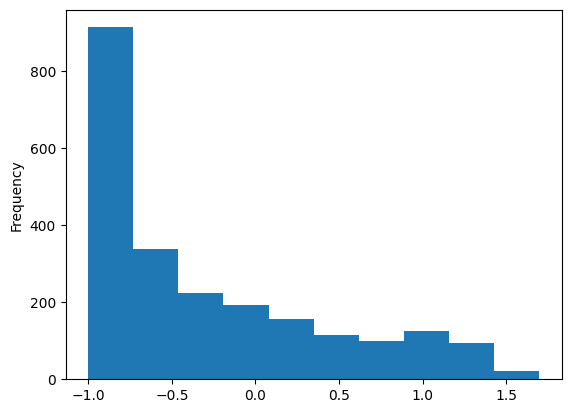

In [14]:
index_df['metric_score_norm'].plot.hist()

In [93]:
data=(
    index_df
    .pivot_table(index='ccTLD',columns='metric',values='metric_score_norm')
    .loc[:,metric_order]
    .assign(maturity_index=lambda r:r.apply(lambda c:c*metric_weight[c.name],axis=0).mean(axis=1))
    .sort_values('maturity_index',ascending=True)
    # .iloc[:,:-1]
    .rename(index=lambda x:x.upper())
)

data
# data['maturity_index'].plot.hist()

# per_plot=35

# for i in range(1+len(data)//per_plot):
#     total = len(data)
#     start = i*per_plot
    
#     if total - start >= per_plot:
#         end = start+per_plot
#     else:
#         end = total

#     fig,ax = plt.subplots(figsize=(10,4))
#     sns.heatmap(data.iloc[start:end,:].T, ax=ax, cmap=sns.cm.rocket_r)
#     ax.set_title(f'Top {total-start} to {total-end+1}')
#     plt.tight_layout()
#     plt.show()
#     plt.close()
# data

metric,nNSes,nIPv4,nIPv6,nPrefixes4,nPrefixes6,nASv4,nASv6,nGeoDiverseNSes,nTLDs,nAnycast4,nAnycast6,nRIRv4,nRIRv6,DNSSEC,maturity_index
ccTLD,,,,,,,,,,,,,,,
TM,1.033210,0.974170,-0.900369,-0.874539,-0.952030,-0.944649,-0.981550,-0.952030,-0.974170,-0.900369,-1.0,-0.992620,-0.963100,-1.000000,-0.930416
LY,1.241830,-0.496732,-0.539216,-0.630719,-0.666667,-0.973856,-0.986928,-0.640523,-0.941176,-0.437908,-1.0,-0.993464,-0.673203,-0.980392,-0.886555
CU,0.872881,0.754237,-0.957627,-0.033898,-1.000000,-0.898305,-1.000000,-0.677966,-0.915254,-0.974576,-1.0,-0.966102,-1.000000,-1.000000,-0.838378
IR,1.063063,-0.148649,-0.657658,-0.468468,-0.779279,-0.747748,-0.986486,-0.554054,-0.864865,-0.599099,-1.0,-0.918919,-0.783784,-1.000000,-0.837516
BF,1.083832,0.323353,-0.628743,-0.574850,-0.862275,-0.796407,-0.958084,-0.730539,-0.880240,-0.550898,-1.0,-0.904192,-0.892216,-1.000000,-0.822498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GL,1.400000,1.300000,0.870000,0.600000,-0.060000,0.080000,-0.680000,0.250000,-0.840000,-0.050000,-1.0,-0.580000,-0.400000,-0.880000,0.269286
CZ,1.157676,0.941909,0.576763,0.539419,0.136929,-0.033195,-0.286307,0.248963,0.024896,-0.161826,-1.0,-0.834025,-0.485477,-0.020747,0.291938
LT,1.374713,1.259770,0.818391,0.629885,-0.039080,-0.402299,-0.958621,0.590805,-0.859770,1.135632,-1.0,-0.554023,-0.066667,-0.972414,0.302135


<Axes: ylabel='Frequency'>

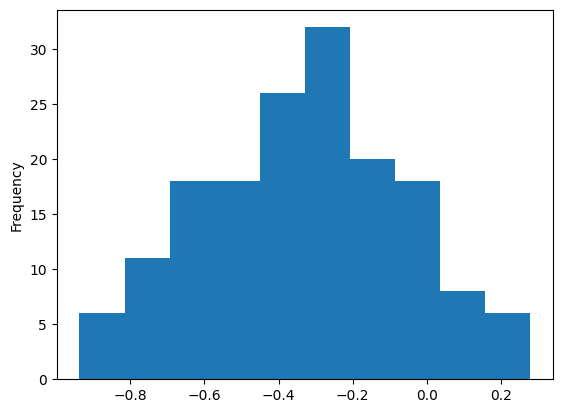

In [38]:
data['maturity_index'].plot.hist()

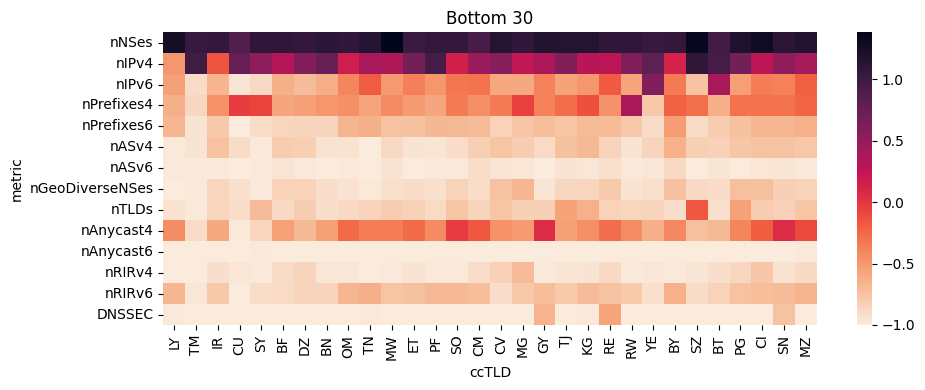

In [16]:
fig,ax = plt.subplots(figsize=(10,4))
sns.heatmap(data.iloc[:30,:-1].T, ax=ax, cmap=sns.cm.rocket_r)
ax.set_title(f'Bottom 30')
plt.tight_layout()
plt.show()
plt.close()

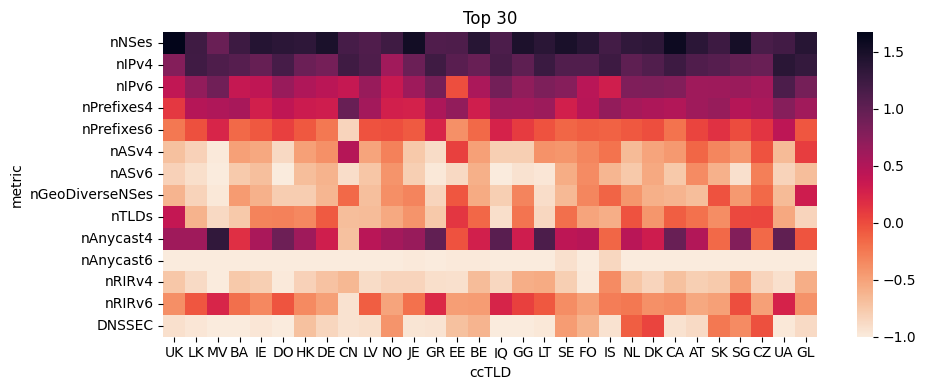

In [17]:
fig,ax = plt.subplots(figsize=(10,4))
sns.heatmap(data.iloc[-30:,:-1].T, ax=ax, cmap=sns.cm.rocket_r)
ax.set_title(f'Top 30')
plt.tight_layout()
plt.show()
plt.close()

<Axes: xlabel='Domain Count', ylabel='Maturity Index'>

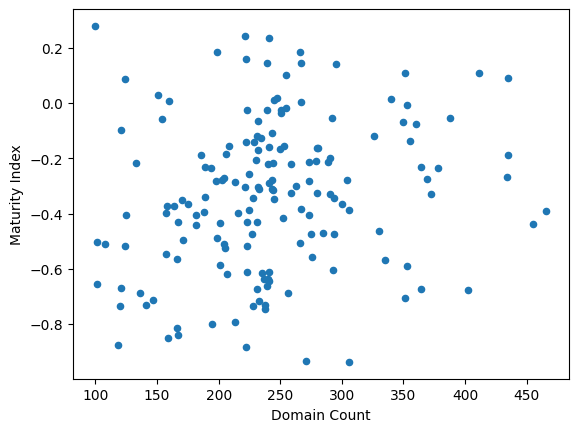

In [18]:
(
    pd.DataFrame([
        data['maturity_index'],
        domain_count.set_axis(domain_count.index.str.upper())
    ]).T.dropna()
    .plot.scatter(x='count',y='maturity_index',xlabel='Domain Count',ylabel='Maturity Index')
)

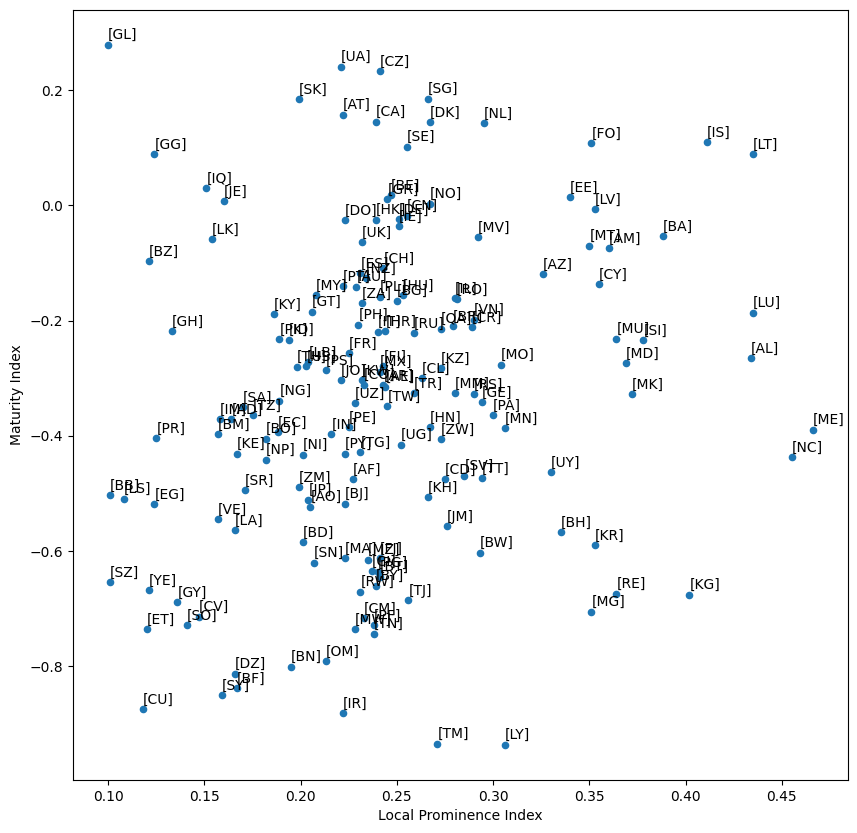

In [37]:
cctld_prominence = domain_count.rename('prominence').set_axis(domain_count.index.str.upper())/1000

scatter_df = (
    pd.DataFrame([
        data['maturity_index'],
        cctld_prominence
    ]).T.dropna()
)

x='prominence'
y='maturity_index'
scatter_df.plot.scatter(x=x,y=y,figsize=(10,10),xlabel='Local Prominence Index',ylabel='Maturity Index')

for i in range(len(scatter_df)): 
    plt.annotate(f'[{scatter_df.index[i]}]', (scatter_df[x][i], scatter_df[y][i]+0.01)) 

In [20]:
import country_converter as coco

In [21]:
scatter_df

,maturity_index,prominence
ccTLD,,
LY,-0.936975,0.306
TM,-0.935161,0.271
IR,-0.882561,0.222
CU,-0.874697,0.118
SY,-0.850404,0.159
...,...,...
SK,0.184494,0.199
SG,0.185553,0.266
CZ,0.233847,0.241


In [22]:
fluorish = pd.read_csv('../datasets/fluorish_country.csv')
fluorish['ISO2'] = coco.convert(names = fluorish['Country name'], to = 'ISO2')
fluorish['ccTLD'] = coco.convert(names = fluorish['Country name'], to = 'ccTLD')
fluorish['ccTLD'] = fluorish.ccTLD.str.upper()
fluorish = fluorish.set_index('ccTLD').drop(index='NOT FOUND').drop_duplicates('ISO2')
fluorish

Guantanamo Bay Naval Base not found in regex
Clipperton Island not found in regex
Sint Eustatius not found in regex
Saba not found in regex
Johnston Atoll not found in regex
Jarvis Island not found in regex
Baker Island not found in regex
Howland Island not found in regex
Wake Island not found in regex
Midway Island not found in regex
Navassa Island not found in regex
Palmyra Atoll not found in regex
Kingman Reef not found in regex
Aksai Chin not found in regex
Arunachal Pradesh not found in regex
Abyei not found in regex
Demchok not found in regex
Guantanamo Bay Naval Base not found in regex
Clipperton Island not found in regex
Sint Eustatius not found in regex
Saba not found in regex
Johnston Atoll not found in regex
Jarvis Island not found in regex
Baker Island not found in regex
Howland Island not found in regex
Wake Island not found in regex
Midway Island not found in regex
Navassa Island not found in regex
Palmyra Atoll not found in regex
Kingman Reef not found in regex
Aksai Chi

,Country name,ISO2
ccTLD,,
ID,Indonesia,ID
MY,Malaysia,MY
CL,Chile,CL
BO,Bolivia,BO
PE,Peru,PE
...,...,...
CC,Cocos Islands,CC
CX,Christmas Islands,CX
TK,Tokelau,TK


In [24]:
data.head()

metric,nNSes,nIPv4,nIPv6,nPrefixes4,nPrefixes6,nASv4,nASv6,nGeoDiverseNSes,nTLDs,nAnycast4,nAnycast6,nRIRv4,nRIRv6,DNSSEC,maturity_index
ccTLD,,,,,,,,,,,,,,,
LY,1.241830,-0.496732,-0.539216,-0.630719,-0.666667,-0.973856,-0.986928,-0.993464,-0.941176,-0.437908,-1.000000,-0.993464,-0.673203,-0.980392,-0.936975
TM,1.033210,0.974170,-0.900369,-0.874539,-0.952030,-0.944649,-0.981550,-0.985240,-0.974170,-0.900369,-1.000000,-0.992620,-0.963100,-1.000000,-0.935161
IR,1.063063,-0.148649,-0.657658,-0.468468,-0.779279,-0.747748,-0.986486,-0.869369,-0.864865,-0.599099,-1.000000,-0.918919,-0.783784,-1.000000,-0.882561
CU,0.872881,0.754237,-0.957627,-0.033898,-1.000000,-0.898305,-1.000000,-0.932203,-0.915254,-0.974576,-1.000000,-0.966102,-1.000000,-1.000000,-0.874697
SY,1.075472,0.528302,-0.886792,-0.075472,-0.911950,-0.974843,-0.987421,-0.987421,-0.710692,-0.867925,-0.987421,-0.987421,-0.911950,-1.000000,-0.850404


In [31]:
# Only index
scatter_df.join(fluorish).to_csv('../datasets/cctld_prominence_maturity_v1.csv')

In [36]:
# Only metrics
fluorish.join(data.iloc[:,:-1],how='inner').to_csv('../datasets/cctld_prominence_maturity_v1_only_metrics.csv')

In [39]:
# Index with metrics
scatter_df.join(fluorish).join(data.iloc[:,:-1]).to_csv('../datasets/cctld_prominence_maturity_v1_with_metrics.csv')